In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('/content/complaints.csv')

In [6]:
print(data.head())
print(data.columns)
print(data.isnull().sum())

   Unnamed: 0           product  \
0           0       credit_card   
1           1       credit_card   
2           2    retail_banking   
3           3  credit_reporting   
4           4  credit_reporting   

                                           narrative  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...  
Index(['Unnamed: 0', 'product', 'narrative'], dtype='object')
Unnamed: 0    0
product       0
narrative     1
dtype: int64


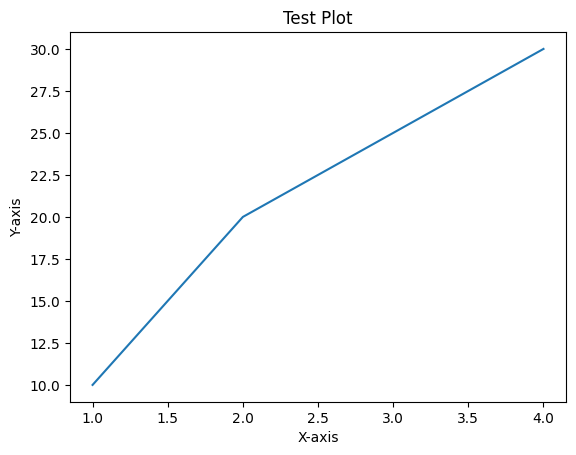

In [7]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3, 4], [10, 20, 25, 30])
plt.title("Test Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [8]:
data['narrative'] = data['narrative'].fillna('')
data['product'] = data['product'].fillna('Unknown')
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['narrative'])
data['product_encoded'] = data['product'].astype('category').cat.codes
y = data['product_encoded']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Cross-validation accuracy
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Accuracy: ", np.mean(cv_scores))

Cross-Validation Accuracy:  0.7654058142806408


In [12]:
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nTest Set Accuracy: ", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.57      0.69        94
           1       0.82      0.96      0.88       553
           2       0.83      0.67      0.74       177
           3       0.85      0.60      0.70       100
           4       0.72      0.72      0.72        64

    accuracy                           0.82       988
   macro avg       0.82      0.70      0.75       988
weighted avg       0.82      0.82      0.81       988


Confusion Matrix:
 [[ 54  27   4   0   9]
 [  1 529  13   8   2]
 [  0  55 119   3   0]
 [  1  26   6  60   7]
 [  6  11   1   0  46]]

Test Set Accuracy:  0.8178137651821862


In [13]:
misclassified_samples = (y_test != y_pred).sum()
print(f"Number of Misclassified Samples: {misclassified_samples}")

Number of Misclassified Samples: 180


In [14]:
# Analyzing Feature Importance
feature_importances = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(),
                                     'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
          Feature  Importance
1059      credit    0.019888
3756      report    0.019846
1132        debt    0.015772
42       account    0.014539
2549        loan    0.013633
422         bank    0.012737
3759   reporting    0.012104
612         card    0.011751
779   collection    0.010932
592       called    0.010712


In [15]:
# Automated Resolution Suggestions
patterns = feature_importances[feature_importances['Importance'] >= 0.02]
print(patterns)

Empty DataFrame
Columns: [Feature, Importance]
Index: []


In [16]:
data['narrative'] = data['narrative'].fillna('No Narrative')
data['product'] = data['product'].fillna('Unknown')

print(data['product'].unique())

['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']


In [17]:
data['combined'] = data['product'] + " - " + data['narrative']
print(data[['product', 'narrative', 'combined']].head())

            product                                          narrative  \
0       credit_card  purchase order day shipping amount receive pro...   
1       credit_card  forwarded message date tue subject please inve...   
2    retail_banking  forwarded message cc sent friday pdt subject f...   
3  credit_reporting  payment history missing credit report speciali...   
4  credit_reporting  payment history missing credit report made mis...   

                                            combined  
0  credit_card - purchase order day shipping amou...  
1  credit_card - forwarded message date tue subje...  
2  retail_banking - forwarded message cc sent fri...  
3  credit_reporting - payment history missing cre...  
4  credit_reporting - payment history missing cre...  


In [18]:
#frequent combinations
common_complaints = data['combined'].value_counts().head(10)
print("Most Common Complaints:")
print(common_complaints)

Most Common Complaints:
combined
credit_reporting - block except otherwise provided section consumer reporting agency shall block reporting information file consumer consumer identifies information resulted alleged identity theft later business day date receipt agency appropriate proof identity consumer copy identity theft report identification information consumer statement consumer information information relating transaction consumer b notification consumer reporting agency shall promptly notify furnisher information identified consumer subsection section information may result identity theft identity theft report filed block requested section effective date block c authority decline rescind general consumer reporting agency may decline block may rescind block information relating consumer section consumer reporting agency reasonably determines information blocked error block requested consumer error b information blocked block requested consumer basis material misrepresentation fac

In [26]:
# resolution mapping (manually curated)
resolution_map = {
    "credit_reporting - Missing payment history": "Verify and update credit report",
    "debt_collection - Unauthorized debt": "Contact collection agency for dispute resolution",
}


data['resolution'] = data['combined'].map(resolution_map).fillna('General Investigation Required')
print(data[['combined', 'resolution']].head())

                                            combined  \
0  credit_card - purchase order day shipping amou...   
1  credit_card - forwarded message date tue subje...   
2  retail_banking - forwarded message cc sent fri...   
3  credit_reporting - payment history missing cre...   
4  credit_reporting - payment history missing cre...   

                       resolution  
0  General Investigation Required  
1  General Investigation Required  
2  General Investigation Required  
3  General Investigation Required  
4  General Investigation Required  


In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encoding attributes
data['product_encoded'] = le.fit_transform(data['product'])
data['narrative_encoded'] = le.fit_transform(data['narrative'])

print(data[['product', 'product_encoded', 'narrative', 'narrative_encoded']].head())

            product  product_encoded  \
0       credit_card                0   
1       credit_card                0   
2    retail_banking                4   
3  credit_reporting                1   
4  credit_reporting                1   

                                           narrative  narrative_encoded  
0  purchase order day shipping amount receive pro...               1980  
1  forwarded message date tue subject please inve...               1371  
2  forwarded message cc sent friday pdt subject f...               1370  
3  payment history missing credit report speciali...               1886  
4  payment history missing credit report made mis...               1885  


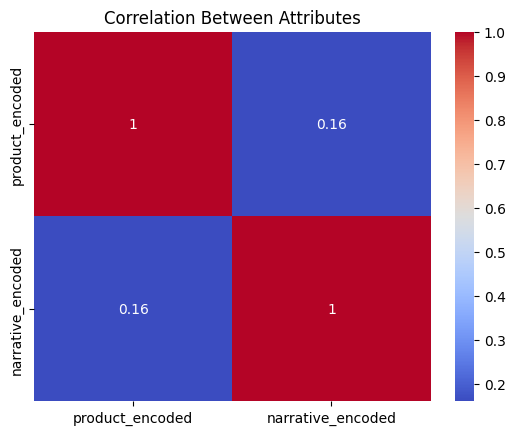

In [21]:
correlation_matrix = data[['product_encoded', 'narrative_encoded']].corr()
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Attributes")
plt.show()

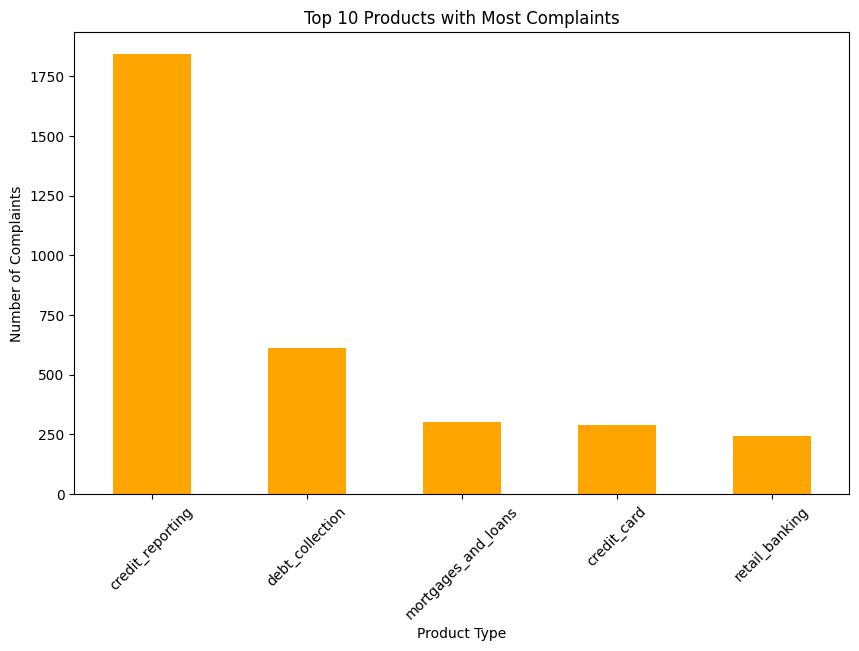

In [22]:
product_complaints = data.groupby('product')['narrative'].count().sort_values(ascending=False)
product_complaints.head(10).plot(kind='bar', color='orange', figsize=(10, 6))
plt.title("Top 10 Products with Most Complaints")
plt.xlabel("Product Type")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Analyze most frequent combined issues for top product
top_product = product_complaints.idxmax()  # Get the product with the most complaints
top_product_issues = data[data['product'] == top_product]['combined'].value_counts().head(10)

# Display top issues for the most complained product
print(f"Top issues for {top_product}:\n", top_product_issues)

Top issues for credit_reporting:
 combined
credit_reporting - block except otherwise provided section consumer reporting agency shall block reporting information file consumer consumer identifies information resulted alleged identity theft later business day date receipt agency appropriate proof identity consumer copy identity theft report identification information consumer statement consumer information information relating transaction consumer b notification consumer reporting agency shall promptly notify furnisher information identified consumer subsection section information may result identity theft identity theft report filed block requested section effective date block c authority decline rescind general consumer reporting agency may decline block may rescind block information relating consumer section consumer reporting agency reasonably determines information blocked error block requested consumer error b information blocked block requested consumer basis material misrepresen

resolution           General Investigation Required
product                                            
credit_card                                     291
credit_reporting                               1843
debt_collection                                 611
mortgages_and_loans                             302
retail_banking                                  244


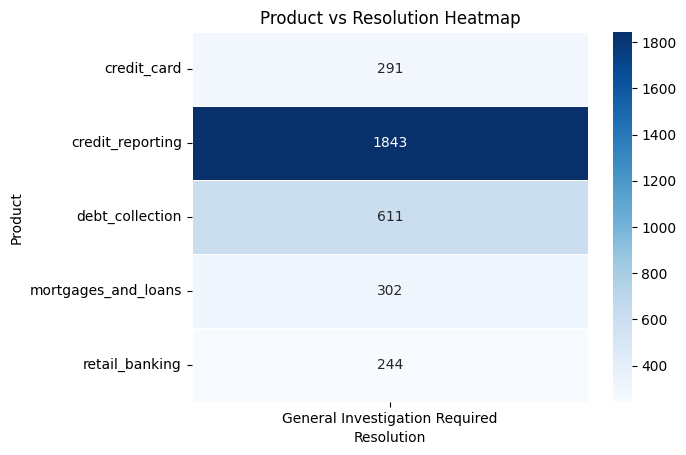

In [24]:
# Cross-tabulation between product and resolution
cross_tab = pd.crosstab(data['product'], data['resolution'])

# Display cross-tab
print(cross_tab)

# Visualize as a heatmap
sns.heatmap(cross_tab, annot=True, fmt="d", cmap='Blues', linewidths=0.5)
plt.title("Product vs Resolution Heatmap")
plt.xlabel("Resolution")
plt.ylabel("Product")
plt.show()

In [25]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(cross_tab)
print("P-value for independence test:", p)

P-value for independence test: 1.0
